In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import HTML
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [2]:
n = 1000 # sample size
c = 0.3 # p/n
alpha = 0.1 # L/n
beta = alpha/c

p = int(c*n) # dimension
L = int(alpha*n) # band size
setting = "$n = {} \quad p = {} \quad L = {}$".format(n, p, L)

# k = 2 # number of classes
# pi = np.array([0.5, 0.5]) # proportion of each class
# # centroid of each class
# mu = stats.norm.rvs(size=(p, 1))
# mu_norm = 2
# mu = mu_norm*mu/np.linalg.norm(mu)
# M = np.concatenate([+mu, -mu], axis=1)
# setting += "$\quad || \mu || = {}$".format(mu_norm)
# easy_setting = True

k = 3 # number of classes
pi = np.array([0.34, 0.33, 0.33]) # proportion of each class
# centroid of each class
cov_mat = np.kron(np.array([[10., 5.5, 2.], [5.5, 15., 4.], [2., 4., 12.]]), np.eye(p))/p
M = stats.multivariate_normal.rvs(cov=cov_mat).reshape((p, k))
M = 10*M/np.sqrt(np.diag((M.T)@M)).min()
easy_setting = False

J = utils.getJ(n, pi)
nbMC = 1 # number of Monte-Carlo simulations

streaming = True
animation = False

# Computations

**Limiting spectral distribution**: we use the fact that, if $m$ is the Stieltjes transform of a measure which has a density $d(x)$ in $x$, then
$$
d(x) = \frac{1}{\pi} \lim_{y \downarrow 0} \Im \left[ m(x + \mathrm{i} y) \right].
$$

In [3]:
# Simulations
eigvals_t, eigvecs_t = utils.simul(nbMC, L, M, J, mask='toeplitz', comp=False)
eigvals_c, eigvecs_c = utils.simul(nbMC, L, M, J, mask='circulant', comp=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


In [4]:
# Get eigenbases
tau, basis_t = utils.basis(n, L, kind='toeplitz')
psi, basis_c = utils.basis(n, L, kind='circulant')

In [5]:
# Limiting spectral distribution
axr = np.linspace(eigvals_c.min(), eigvals_c.max(), 1000)
eta0_t = utils.eta0(axr, n, p, L, tau)
eta0_c = utils.eta0(axr, n, p, L, psi)
LSD_t = (1/(1-axr-eta0_t)).imag/np.pi
LSD_c = (1/(1-axr-eta0_c)).imag/np.pi

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1062.53it/s]


In [6]:
# Get spikes and alignments
if easy_setting:
    spikes_c, spikes_t = utils.get_spikes(n, p, L, mu_norm)
    spikes_idx_c, spikes_c, zeta_c, natural_idx_c = spikes_c
    spikes_idx_t, spikes_t, zeta_t, natural_idx_t = spikes_t

# Visualisation

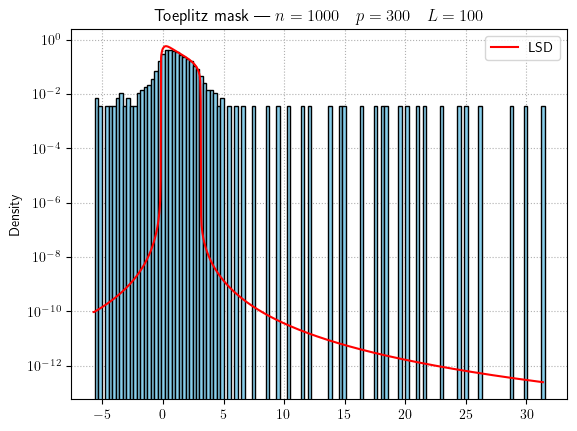

In [7]:
plt.hist(eigvals_t.flatten(), bins='auto', color='skyblue', edgecolor='black', density=True, zorder=2)
plt.plot(axr, LSD_t, color='red', label="LSD")
if easy_setting:
    for spike in spikes_t:
        plt.axvline(x=spike, ls=':', color='green')
plt.grid(ls=':')
plt.yscale('log')
plt.ylabel("Density")
plt.legend()
plt.title("Toeplitz mask | "+setting)
plt.show()

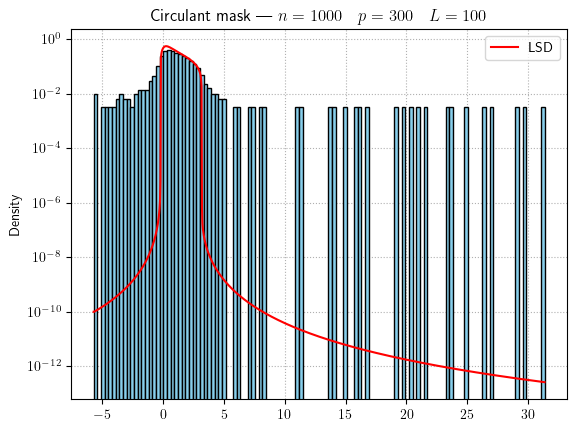

In [8]:
plt.hist(eigvals_c.flatten(), bins='auto', color='skyblue', edgecolor='black', density=True, zorder=2)
plt.plot(axr, LSD_c, color='red', label="LSD")
if easy_setting:
    for spike in spikes_c:
        plt.axvline(x=spike, ls=':', color='green')
plt.grid(ls=':')
plt.yscale('log')
plt.ylabel("Density")
plt.legend()
plt.title("Circulant mask | "+setting)
plt.show()

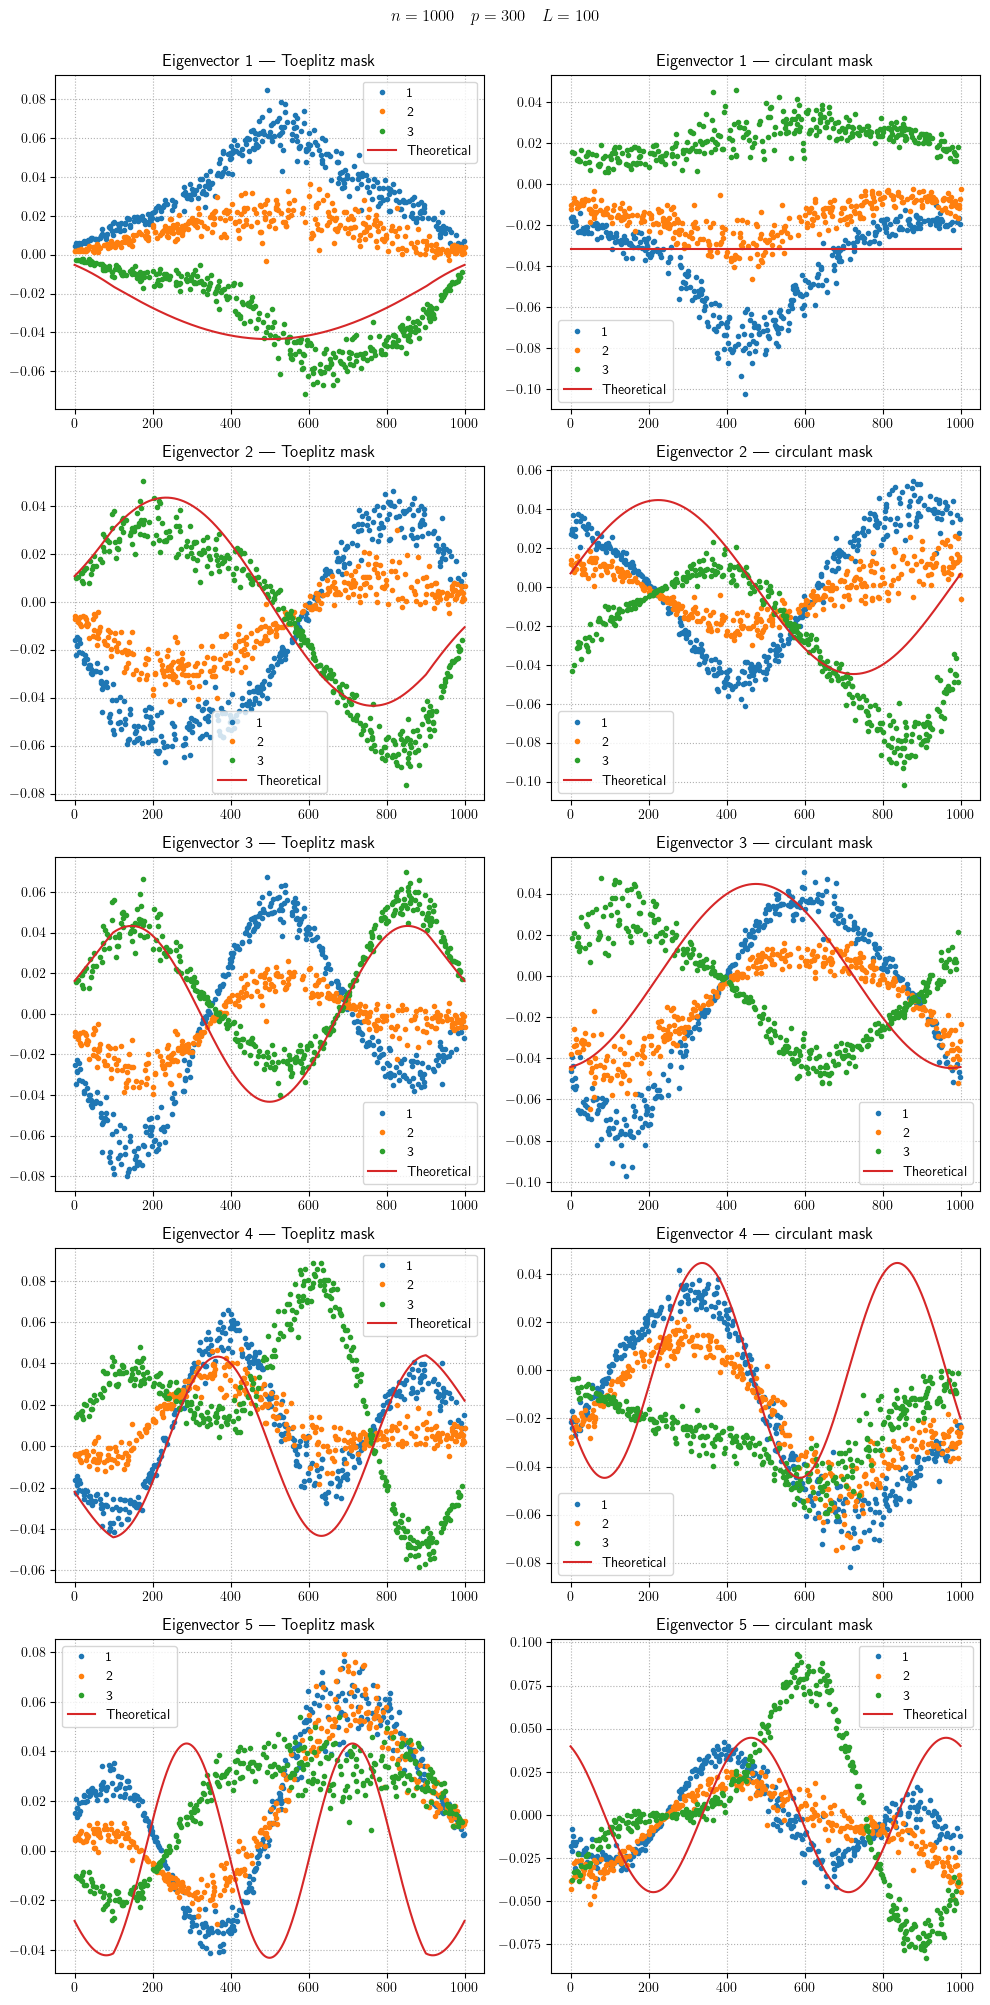

In [9]:
x = np.arange(n)
n_to_plot = 5
to_plot = spikes_idx_t[:n_to_plot] if easy_setting else np.arange(n-1, n-1-n_to_plot, -1)

fig, ax = plt.subplots(n_to_plot, 2, figsize=(10, 4*n_to_plot), squeeze=False)
for ii, i in enumerate(to_plot):
    for j in range(k):
        cl = (J[:, j] == 1)
        ax[ii, 0].plot(x[cl], eigvecs_t[0, i, cl], ls='', marker='.', label=j+1)
        ax[ii, 1].plot(x[cl], eigvecs_c[0, i, cl], ls='', marker='.', label=j+1)
    ax[ii, 0].plot(x, basis_t[i], label="Theoretical")
    ax[ii, 1].plot(x, basis_c[i], label="Theoretical")
    ax[ii, 0].grid(ls=':')
    ax[ii, 1].grid(ls=':')
    ax[ii, 0].set_title("Eigenvector {} | Toeplitz mask".format(n-i))
    ax[ii, 1].set_title("Eigenvector {} | circulant mask".format(n-i))
    ax[ii, 0].legend()
    ax[ii, 1].legend()
fig.suptitle(setting, y=1)
fig.tight_layout()
plt.show()

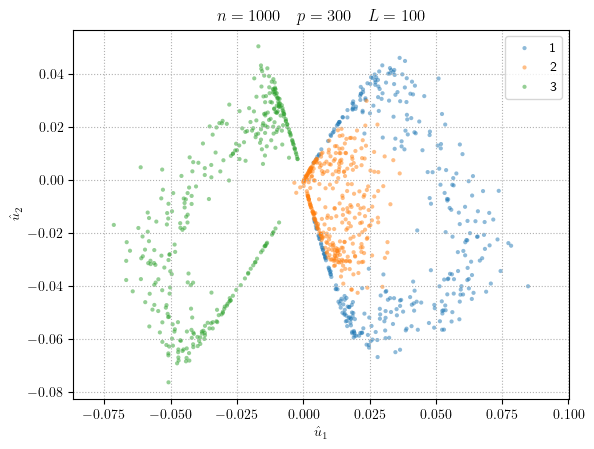

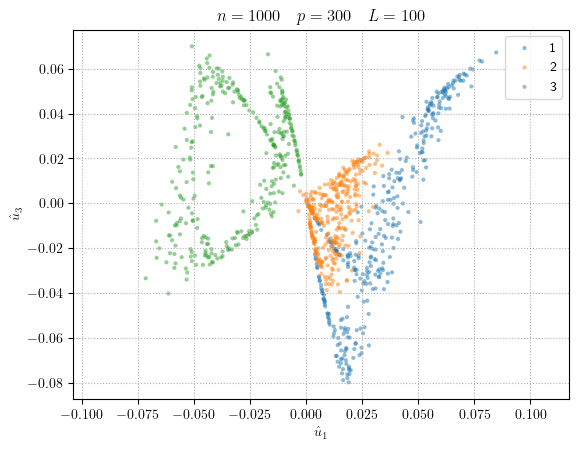

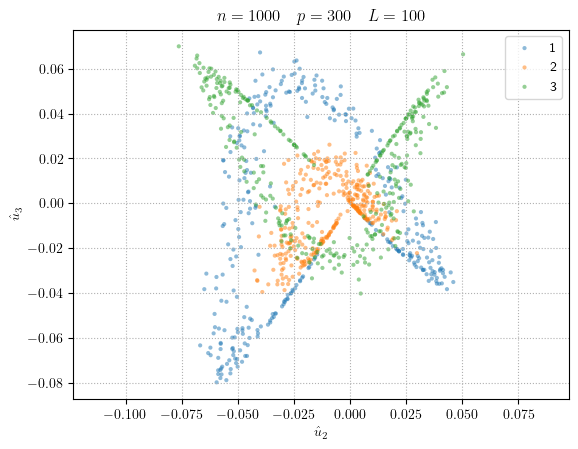

In [10]:
to_plot = np.array([[0, 1], [0, 2], [1, 2]])
to_plot = spikes_idx_t[to_plot] if easy_setting else n-1-to_plot

for i, [a, b] in enumerate(to_plot):
    for j in range(k):
        cl = (J[:, j] == 1)
        x, y = eigvecs_t[0, a, cl], eigvecs_t[0, b, cl]
        plt.scatter(x, y, marker='.', edgecolors='none', alpha=.5, label=j+1)
    plt.grid(ls=':')
    plt.axis('equal')
    plt.xlabel("$\\hat{{u}}_{{{}}}$".format(n-a))
    plt.ylabel("$\\hat{{u}}_{{{}}}$".format(n-b))
    plt.legend()
    plt.title(setting)
    plt.show()

# Classification

In [11]:
import scipy.linalg as linalg
from itertools import permutations

In [12]:
if easy_setting:
    print("Optimal classification error: {:.2%}".format(stats.norm.sf(np.sqrt(zeta_t[0]/(1-zeta_t[0])))))

In [13]:
idx_eigvecs = [-1, -2, -3, -4, -5] # eigenvectors used for the classification
idx_basis = [-1, -2, -3, -4, -5] # Toeplitz basis
Lip = np.max(linalg.norm(np.diff(basis_t[idx_basis], axis=1), axis=0))

In [14]:
%%time
partition, details = utils.classification(n, k, eigvecs_t[0], idx_eigvecs, basis_t, idx_basis)

Wall time: 70.7 ms


In [15]:
curves, reg, exp_smooth, partition0, n_tries = details
print("N tries: {}".format(n_tries))

N tries: 2


In [16]:
permut = np.array(list(permutations(range(k))))
c_err = np.min([np.mean(p[partition] != np.argmax(J, axis=1)) for p in permut])
print("Classification error: {:.2%}".format(c_err))

Classification error: 1.20%


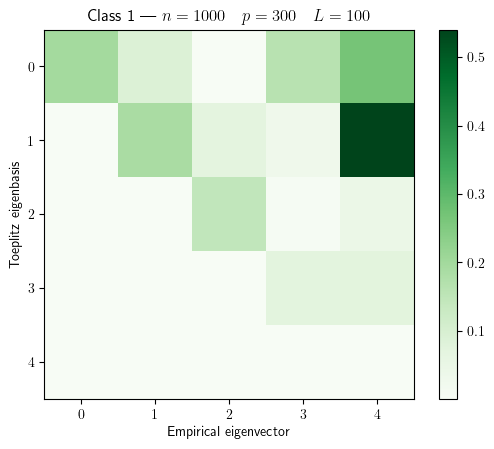

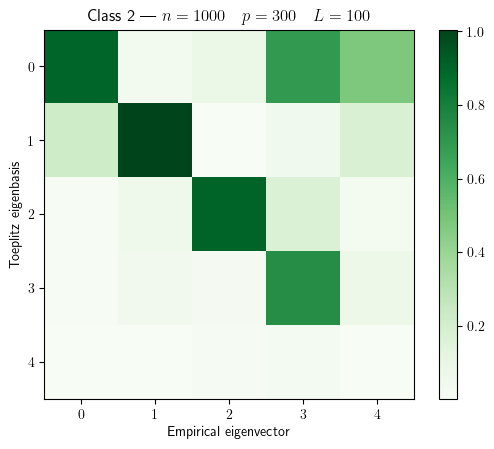

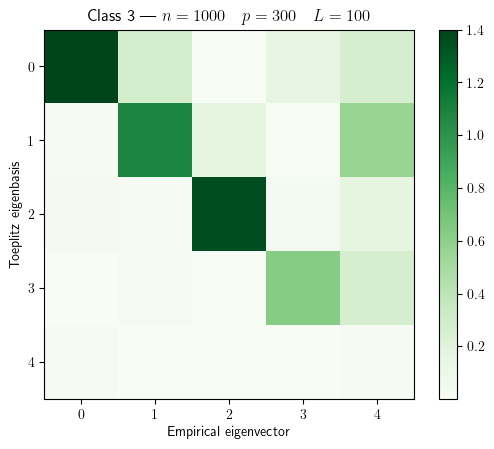

In [17]:
for j in range(k):
    plt.colorbar(plt.imshow(reg[j]**2, interpolation='none', cmap='Greens'))
    plt.xlabel("Empirical eigenvector")
    plt.ylabel("Toeplitz eigenbasis")
    plt.title("Class {} | ".format(j+1)+setting)
    plt.show()

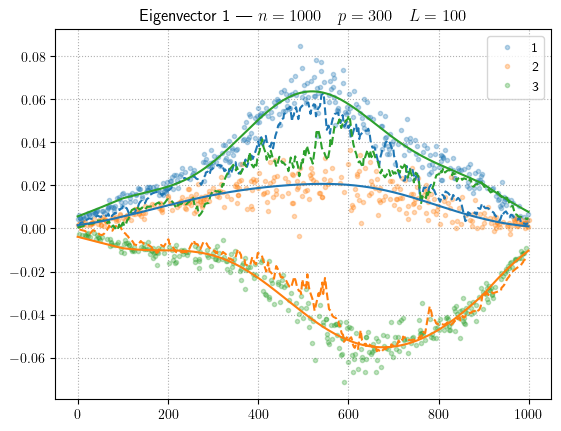

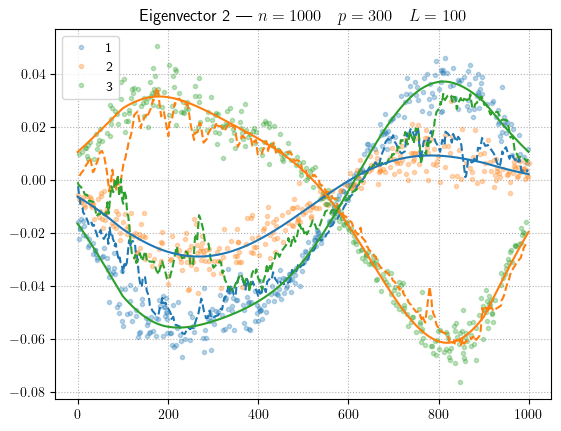

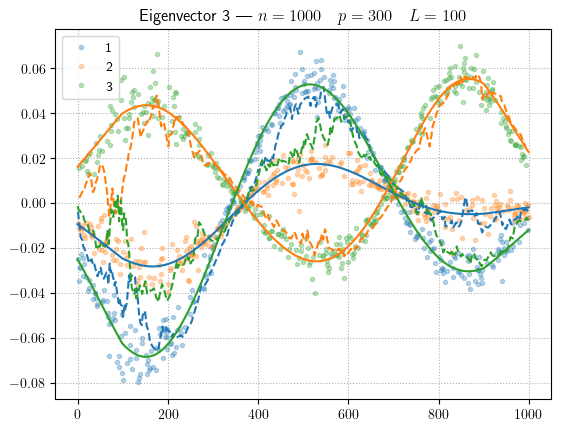

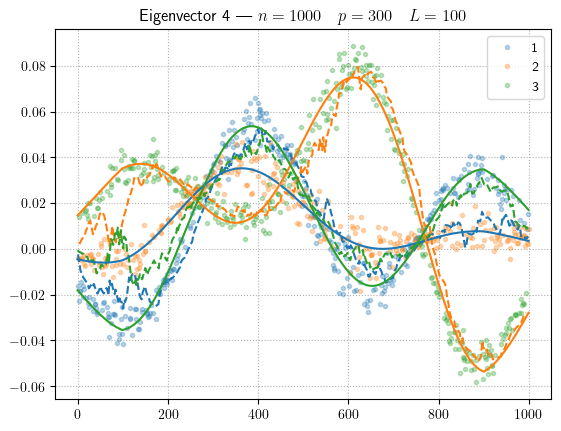

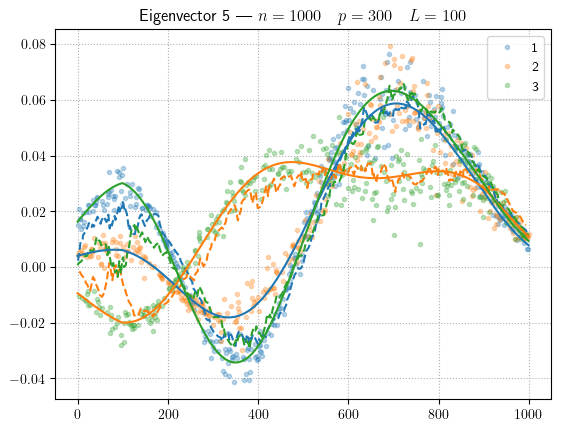

In [18]:
plot_true = True

x = np.arange(n)
for ll, l in enumerate(idx_eigvecs):
    for j in range(k):
        cl = (J[:, j] == 1) if plot_true else (partition == j)
        plt.plot(x[cl], eigvecs_t[0, l, cl], ls='', marker='.', label=j+1, alpha=.3, c='C'+str(j), zorder=2)
        plt.plot(x[partition0 == j], exp_smooth[ll, partition0 == j], ls='--', c='C'+str(j), zorder=3)
        plt.plot(x, curves[j, ll], ls='-', c='C'+str(j), zorder=4)
    plt.grid(ls=':')
    plt.legend()
    plt.title("Eigenvector {} | ".format((n-l)%n)+setting)
    plt.show()

# Streaming

In [19]:
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import eigsh
from tqdm import tqdm

In [20]:
if streaming:
    T = 3*n
    n_eigvecs = 5
    
    streaming_setting = "$T = {} \\quad$".format(T)+setting
    
    # Create artificial data
    JT = utils.getJ(T, pi)
    P = M@(JT.T) # signal
    Z = stats.norm.rvs(size=(p, T)) # noise
    X = Z+P # observation
    
    # Initialisation
    K_data = np.zeros((T, L)) # sparse kernel matrix, (n, L) in practice
    lbda = np.zeros((T, n_eigvecs)) # top eigenvalues
    w = np.ones((T, n, n_eigvecs)) # top eigenvectors
    
    def make_K(K_data):
        data_u = K_data.T
        offsets_u = np.arange(L)
        K_u = dia_matrix((data_u, offsets_u), shape=(n, n))
        data_l = K_data[:, 1:].T
        offsets_l = np.arange(1, L)
        K_l = dia_matrix((data_l, offsets_l), shape=(n, n)).T
        return K_u+K_l
    
    # Streaming
    for t in tqdm(range(T)):
        tL = max(0, t-L+1) # data is kept from tL to t
        K_data[t, :t-tL+1] = (X[:, t]@X[:, tL:t+1]/p)[::-1]
        t_obs = max(0, t-n+1) # data is clustered from t_obs to t
        K = make_K(K_data[t_obs:t_obs+n]) # make the (n, n) sparse kernel matrix
        # Compute top eigenpairs
        if t >= n_eigvecs:
            lbda[t], w[t] = eigsh(K, k=n_eigvecs, v0=w[t-1, :, 0], which='LA')
        else:
            lbda[t, -t-1:], w[t, :, -t-1:] = eigsh(K, k=t+1, v0=w[t-1, :, 0], which='LA')
        # Sign correction
        if t >= n:
            w[t] *= np.sign(np.sum(w[t, :-1]*w[t-1, 1:], axis=0))
        elif t > 0:
            w[t] *= np.sign(np.sum(w[t]*w[t-1], axis=0))
    w = np.transpose(w[:, :, ::-1], (0, 2, 1))
    lbda = lbda[:, ::-1]

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:45<00:00, 28.37it/s]


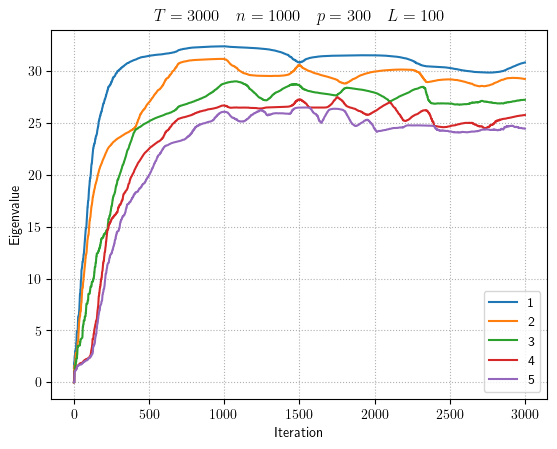

In [21]:
if streaming:
    plt.plot(lbda)
    plt.grid(ls=':')
    plt.xlabel("Iteration")
    plt.ylabel("Eigenvalue")
    plt.title(streaming_setting)
    plt.legend(np.arange(1, n_eigvecs+1))
    plt.show()

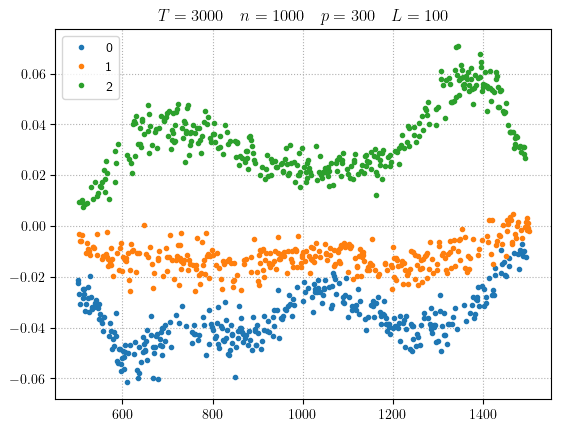

In [22]:
if streaming:
    t = T//2
    i = 0

    x = np.arange(max(0, t-n+1), max(n, t+1))
    for j in range(k):
        cl = (JT[max(0, t-n+1):t+1, j] == 1)
        cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
        plt.plot(x[cl], w[t, i, cl], ls='', marker='.', label=j)
    plt.grid(ls=':')
    plt.title(streaming_setting)
    plt.legend()
    plt.show()

In [23]:
if streaming and easy_setting:
    s_, t_ = np.meshgrid(np.arange(n), np.arange(T))
    mask = (t_+s_ >= T)
    s_[mask] = 0
    classif = np.sign(w[t_+s_, 0, np.minimum(t_, n-1-s_)])
    classif[mask] = 0

In [24]:
if streaming and easy_setting:
    err_streaming = (np.repeat(JT[:, 0]-JT[:, 1], n).reshape((T, n)) != classif)
    mean_err_streaming = np.mean(err_streaming[n:-n], axis=0)
    mean_err_streaming = np.minimum(mean_err_streaming, 1-mean_err_streaming)

In [25]:
if streaming and easy_setting:
    plt.plot(mean_err_streaming, ls='-', marker='')
    plt.grid(ls=':')
    plt.xlabel("Delay")
    plt.ylabel("Classification error")
    plt.title(setting)
    plt.show()

In [26]:
if animation:
    i = 0

    fig, ax = plt.subplots()

    for j in range(k):
        ax.plot([], ls='', marker='.', label=j)
    ax.grid(ls=':')
    ax.set_title(streaming_setting)
    ax.legend()

    def animate(t):
        x = np.arange(max(0, t-n+1), max(n, t+1))
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim((w[t, i].min(), w[t, i].max()))
        for j in range(k):
            cl = (JT[max(0, t-n+1):t+1, j] == 1)
            cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
            ax.lines[j].set_data((x[cl], w[t, i, cl]))

    anim = FuncAnimation(fig, animate, frames=T, interval=30*1000/T, repeat=False)
    HTML(anim.to_html5_video())